# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [1]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
# import os
# import pickle
import pytorch_forecasting
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE, MASE
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
from tft_helper import *

import os
import sys

basepath = os.path.abspath("")  # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta

c:\Users\nicov\anaconda3\envs\tft\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# PARAMS

In [2]:
seq_len = 5 #sequence lenght: how many timesteps does a sequence have. For example a week could be considered a single sequence, therefore seq_len would be 5 as as the stock market opens 5 days a week.
pred_len = seq_len * 5 # prediction lenght: How many timesteps does a prediction sequence have. For example if each prediction is a full week pred_len should be 5 as the stock market opens 5 days a week.
n_prev_len = 100 # Number of previous timesteps to take for inference. 
n_preds = 5 # number of predictions with test data
test_len = pred_len * n_preds  # Number of timesteps to use for test data.
group = "group" # If a same model should predict different stores, indices etc specify how to group them. If theres only one time series the set group col to one full of the same value.
n_lags = seq_len * 20  # Number of lags to use.
loss = MAPE() # Loss function. 
epochs = 75 # Epochs to train the model.

# Set ts date range
date_start = '2010-01-04' #None #"2023-06-01"
date_end = "2024-7-29"
shift = 1 # How many times to shift values. Useful for using last indicator values (RSI, MACD...) for inference
ma_periods = [ 5, 10, 20, 50, 100, 200] # Moving averages periods
# cols_to_shift = [2:]

# Set training config.
lr_finder = False
grid_search = "random"
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# TFT training params.
tft_params =  {"gradient_clip_val": 0.03, "hidden_size": 24, "dropout": 0.25, "hidden_continuous_size": 24, "attention_head_size": 4, "learning_rate": 0.01, "loss": loss, "early_stop_callback": early_stop_callback}


PIB_relevant_countries = ['USA',
 'CHN',
 'EMU',
 'DEU',
 'FRA',
 'GBR',
 'JPN',
 'IND',
 'BRA',
 'CAN',
 'AUS',
 'ITA',
 'KOR',
 'MEX',
 'IDN',
 'SAU',
 'ZAF',
 'TUR',
 'ESP']

# If grid search, set param grid.
param_grid = {
    "gradient_clip_val": [0.01, 0.03, 0.05],
    "hidden_size": [8, 16, 32],
    "dropout": [0.1, 0.25, 0.4],
    "hidden_continuous_size": [8, 16, 32],
    "attention_head_size": [2, 4, 8],
    "learning_rate": [0.005, 0.01, 0.03],
    "loss": [loss],
    "test_len": [test_len],
    "pred_len": [pred_len],
    "n_prev_len": [n_prev_len],
}

# LOAD DATA

In [3]:
# Load time series data.
df_nasdaq = load_file(file_name="Nasdaq", path="./data/", ftype="csv")
df_nasdaq = investing_preprocessing(df_nasdaq)
df_nasdaq['group'] = 'nasdaq'

df_ibex35 = load_file(file_name="Datos históricos del IBEX 35", path="./data/", ftype="csv")
df_ibex35 = investing_preprocessing(df_ibex35)
df_ibex35['group'] = 'ibex35'

df_syp500 = load_file(file_name="S&P500", path="./data/", ftype="csv")
df_syp500 = investing_preprocessing(df_syp500)
df_syp500['group'] = 'syp500'

df_eustoxx = load_file(file_name="EUStoxx50", path="./data/", ftype="csv")
df_eustoxx = investing_preprocessing(df_eustoxx)
df_eustoxx['group'] = 'eustoxx50'



df_ibex35 = add_global_indicators(df_ibex35, PIB_relevant_countries, date_start, date_end)
df_nasdaq = add_global_indicators(df_nasdaq, PIB_relevant_countries, date_start, date_end)
df_syp500 = add_global_indicators(df_syp500, PIB_relevant_countries, date_start, date_end)
df_eustoxx = add_global_indicators(df_eustoxx, PIB_relevant_countries, date_start, date_end)

Dataset does not contain volume data.


## ADD INDICATORS


In [4]:

df_nasdaq = add_indicators(df_nasdaq, n_lags, ma_periods)   
df_syp500 = add_indicators(df_syp500, n_lags, ma_periods)   
df_ibex35 = add_indicators(df_ibex35, n_lags, ma_periods)   
df_eustoxx = add_indicators(df_eustoxx, n_lags, ma_periods)   


    # Agregar Parabolic SAR (sin período, pero podrías ajustar los factores de aceleración)
    # data = add_parabolic_sar(data)

    # Agregar Ichimoku Cloud (no requiere período)
    # df = add_ichimoku(df)

    # Calculate ATR (Average True Range)

    # df["ATR"] = ta.ATR(df["max"], df["min"], df["close"], timeperiod=14)

    # Calculate ADX (Average Directional Index)
    # df["ADX"] = ta.ADX(df["max"], df["min"], df["close"], timeperiod=14)


    # # Calculate CCI (Commodity Channel Index)
    # df["CCI"] = ta.CCI(df["max"], df["min"], df["close"], timeperiod=14)

    # # Calculate OBV (On-Balance Volume)
    # df["OBV"] = ta.OBV(df["close"], df["vol"])

    # # Calculate Stochastic Oscillator (SlowK, SlowD)
    # df["SlowK"], df["SlowD"] = ta.STOCH(df["max"], df["min"], df["close"], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

    # df["WilliamsR"] = ta.WILLR(df["max"], df["min"], df["close"], timeperiod=14)

In [5]:
# Shift indicator values
for df in [df_ibex35, df_nasdaq, df_syp500, df_eustoxx]:
    cols_to_shift = [col for col in df.columns[3:] if not (col.startswith('AAII') or col.startswith('PIB'))]
    df[cols_to_shift] = df[cols_to_shift].shift(shift)


# Usamos todas las series temporales de forma individual para entrenar el modelo.
df = pd.concat([df_syp500, df_ibex35, df_nasdaq, df_eustoxx]).reset_index(drop=True).bfill().ffill()


In [6]:
df

,Date,target,open,max,min,var,group,AAII_Bullish,AAII_Neutral,AAII_Bearish,...,bearish_rsi,bullish_bollinger,bearish_bollinger,bullish_macd,bearish_macd,bullish_atr,bearish_atr,bullish_trend,bearish_trend,vol
0,2010-01-04,1133.00,1116.60,1133.90,1116.60,1.61,syp500,0.410000,0.330000,0.260000,...,0,0,0,0,0,0,0,0,0,184130000.0
1,2010-01-05,1136.50,1132.70,1133.90,1116.60,1.61,syp500,0.410000,0.330000,0.260000,...,0,0,0,0,0,0,0,0,0,184130000.0
2,2010-01-06,1137.10,1135.70,1136.60,1129.70,0.31,syp500,0.410000,0.330000,0.260000,...,0,0,0,1,0,0,0,0,0,184130000.0
3,2010-01-07,1141.70,1136.30,1139.20,1134.00,0.05,syp500,0.410000,0.330000,0.260000,...,0,0,0,1,0,0,0,0,0,184130000.0
4,2010-01-08,1145.00,1140.50,1142.50,1131.30,0.40,syp500,0.410000,0.330000,0.260000,...,0,0,0,1,0,0,0,0,0,184130000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14385,2024-07-23,4916.80,4906.89,4911.43,4833.17,1.45,eustoxx50,0.527473,0.238095,0.234432,...,0,0,0,0,1,1,0,0,0,23100000.0
14386,2024-07-24,4861.87,4892.66,4949.27,4896.33,0.40,eustoxx50,0.527473,0.238095,0.234432,...,0,0,0,0,1,1,0,0,0,20670000.0
14387,2024-07-25,4811.28,4832.68,4892.66,4847.39,-1.12,eustoxx50,0.431734,0.250923,0.317343,...,0,0,0,0,1,1,0,0,0,25420000.0
14388,2024-07-26,4862.50,4810.87,4832.68,4767.15,-1.04,eustoxx50,0.431734,0.250923,0.317343,...,0,0,0,0,1,1,0,0,0,27180000.0


Variables de tipo fecha a numericas

In [7]:
# data = df.copy()
# data["group"] = 1

# # Supongamos que tu DataFrame se llama 'data' y que la columna 'Date' tiene las fechas
# # Crear una lista de días festivos (ejemplo, agrega tus días festivos)
# dias_festivos = pd.to_datetime(["2024-01-01", "2024-12-25", ])  # Añade más días festivos

# # Meses del año (de 1 a 12, de manera categórica)
# data["month"] = data["Date"].dt.month.astype("category")

# # Días del año (de 1 a 365 o 366 en años bisiestos)
# data["day_of_year"] = data["Date"].dt.dayofyear.astype("category")

# # Días de la semana (de lunes a viernes: 0 = lunes, 4 = viernes)
# data["weekday"] = data["Date"].dt.weekday
# data = data[data["weekday"] < 5]  # Eliminar sábados (5) y domingos (6)

# # Identificar si el día es festivo (1 si es festivo, 0 si no lo es)
# data["is_holiday"] = data["Date"].isin(dias_festivos).astype(int)

# # data["time_idx"] = data.groupby(group).cumcount()

# data["time_idx"] = data.index

# # data["Low"].fillna(method="ffill", inplace=True)
# # data["High"].fillna(method="ffill", inplace=True)


Variables de tipo fecha a strings categoricos (La libreria requiere esta opcion)

In [8]:
data = df.copy()
# data["group"] = 1

# Supongamos que tu DataFrame se llama 'data' y que la columna 'Date' tiene las fechas
# Crear una lista de días festivos (ejemplo, agrega tus días festivos)
dias_festivos = pd.to_datetime(["2024-01-01", "2024-12-25", ])  # Añade más días festivos

# Meses del año (convertir a nombres de meses)
data["month"] = data["Date"].dt.strftime('%B')  # Ejemplo: "January", "February", etc.

# Días del año (de 1 a 365 o 366 en años bisiestos), convertir en cadena
data["day_of_year"] = data["Date"].dt.dayofyear.astype(str)  # Convertir el número de día a cadena

# Días de la semana (de lunes a viernes: 0 = lunes, 4 = viernes), convertir a nombre de día
data["weekday"] = data["Date"].dt.strftime('%A')  # Ejemplo: "Monday", "Tuesday", etc.

# Filtrar para eliminar sábados y domingos
data = data[data["weekday"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

# Identificar si el día es festivo (usar "Yes" o "No" en lugar de 1 o 0)
data["is_holiday"] = data["Date"].isin(dias_festivos).map({True: "Yes", False: "No"})

data["time_idx"] = data.index


## TRAIN - TEST SPLIT

In [9]:
# full = data.copy()

# data = full[:-test_len]
# test = full[-test_len:]
# # test["target"] = 0
# data = data.reset_index(drop=True)
# data = data.dropna()


# plt.figure(figsize=(10, 6))
# plt.plot(data["Date"], data["target"], color="blue", label="Train")
# plt.plot(test["Date"], test["target"], color="green", label="Test")

# plt.xlabel("Fecha y Hora")
# plt.ylabel("Precio Spot")
# plt.title("Precio Spot en función de Fecha y Hora")
# plt.legend()
# plt.grid(True)
# plt.show()

<!-- ## DF FINL -->

## TimeSeriesDataset

In [10]:
# Reemplaza '.' con NaN en todas las columnas, o convierte los valores no numéricos
# data.replace(".", np.nan, inplace=True)
# Asegúrate de que todas las columnas relevantes estén en formato numérico
cols_to_convert = ["target", "open", "max", "min", "var", "SMA_5", "EMA_5", "SMA_10", "EMA_10", "SMA_20", "EMA_20",
                   "Bollinger_Upper_20", "Bollinger_Lower_20", "MACD", "Signal_Line", "CCI_10", "CCI_20", "ROC_10",
                   "ROC_14", "ROC_20", "Stochastic_14_K", "Stochastic_14_D", "Williams_%R_14", "VIX"]

data[cols_to_convert] = data[cols_to_convert].apply(pd.to_numeric, errors='coerce')
data = data.ffill().bfill()

In [11]:
max_prediction_length = pred_len
max_encoder_length = n_prev_len 
# Ajusta training_cutoff para reservar un rango más amplio para la validación
validation_size = 50  # ajusta según el tamaño deseado para el conjunto de validación
training_cutoff = data["time_idx"].max() - max_prediction_length - validation_size

train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["month", "weekday", "day_of_year", "is_holiday"],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Date", "time_idx", 'AAII_Bullish',	'AAII_Neutral',	'AAII_Bearish', 'FEDFUNDS'] +
                                        [col for col in df.columns if col.startswith('PIB')],
    time_varying_unknown_categoricals=[
        'bullish_sma_50_200',
        'bearish_sma_50_200',
        'bullish_rsi',
        'bearish_rsi',
        'bullish_bollinger',
        'bearish_bollinger',
        'bullish_macd',
        'bearish_macd',
        'bullish_atr',
        'bearish_atr',
        'bullish_trend',
        'bearish_trend'],
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        # "vol",
        "var",
        "target_lag1",
        "target_lag2",
        "target_lag3",
        "target_lag4",
        "target_lag5",
        "SMA_5",
        "EMA_5",
        "SMA_10",
        "EMA_10",
        # "SMA_15",
        # "EMA_15",
        "SMA_20",
        "EMA_20",
        # "RSI_20",
        "Bollinger_Upper_20",
        "Bollinger_Lower_20",
        "MACD",
        "Signal_Line",
        # "ATR_20",
        "CCI_10",
        "CCI_20",
        "ROC_10",
        "ROC_14",
        "ROC_20",
        "Stochastic_14_K",
        "Stochastic_14_D",
        "Williams_%R_14",
        "VIX",
        "EUVIX"
        # "target_ibex35",
        # "target_nasdaq",
    ],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "weekday": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "day_of_year": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    },
)

validation = TimeSeriesDataSet.from_dataset(train,  data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = train.to_dataloader(
    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True
)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

In [12]:
validation

TimeSeriesDataSet[length=4](
	time_idx='time_idx',
	target='target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=0,
	min_prediction_length=25,
	max_prediction_length=25,
	static_categoricals=[],
	static_reals=['target_center', 'target_scale'],
	time_varying_known_categoricals=['month', 'weekday', 'day_of_year', 'is_holiday'],
	time_varying_known_reals=['Date', 'time_idx', 'AAII_Bullish', 'AAII_Neutral', 'AAII_Bearish', 'FEDFUNDS', 'PIB_USA', 'PIB_CHN', 'PIB_EMU', 'PIB_DEU', 'PIB_FRA', 'PIB_GBR', 'PIB_JPN', 'PIB_IND', 'PIB_BRA', 'PIB_CAN', 'PIB_AUS', 'PIB_ITA', 'PIB_KOR', 'PIB_MEX', 'PIB_IDN', 'PIB_SAU', 'PIB_ZAF', 'PIB_TUR', 'PIB_ESP', 'relative_time_idx'],
	time_varying_unknown_categoricals=['bullish_sma_50_200', 'bearish_sma_50_200', 'bullish_rsi', 'bearish_rsi', 'bullish_bollinger', 'bearish_bollinger', 'bullish_macd', 'bearish_macd', 'bullish_atr', 'bearish_atr', 'bullish_trend', 'bearish_trend'],
	time_varying_unknown_r


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [13]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

## TRAIN MODEL

In [14]:
if not grid_search:
    # tft_params["learning_rate"] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, **tft_params)

### EVAL MODEL

In [15]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


In [16]:
import torch
torch.cuda.is_available()

False

## GRID SEARCH

In [ ]:
if grid_search == "random":
    # Suprime todos los warnings
    warnings.filterwarnings("ignore")

    # Llamada a la función de búsqueda aleatoria
    best_model, best_params, best_val_loss = random_hyperparameter_search(
        data,
        train,
        train_dataloader,
        val_dataloader,
        'a',
        param_grid,
        n_iterations=100,
        max_epochs=70,
        save_dir=f'plots_-{n_prev_len}d-{date_start.replace("-","")}-{date_end.replace("-","")}-lessFilters',
        csv_file=f"./results/mutits_group-{n_prev_len}d-{date_start}-{date_end}.csv",
    )


 -------------------------------------------------------- 
 Probando combinación aleatoria 1/100: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 32, 'attention_head_size': 2, 'learning_rate': 0.03, 'loss': MAPE(), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000162FFDCF550>
Traceback (most recent call last):
  File "c:\Users\nicov\anaconda3\envs\tft\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\nicov\anaconda3\envs\tft\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "c:\Users\nicov\anaconda3\envs\tft\lib\site-packages\torch\utils\data\dataloader.py", line 1379, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (self._persistent_workers and shutdown)
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Number of parameters in network: 78.9k
Training time:  24.307736


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 2/100: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.4, 'hidden_continuous_size': 16, 'attention_head_size': 2, 'learning_rate': 0.005, 'loss': MAPE(), 'test_len': 125, 'pred_len': 25, 'n_prev_len': 100}
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

In [15]:
if grid_search == "exhaustive":
    
    # Suprime todos los warnings 

    
    warnings.filterwarnings("ignore")
    
    # Llamada a la función de búsqueda de hiperparámetros
    best_model, best_params, best_val_loss = exhaustive_hyperparameter_search(
        data, train, train_dataloader, val_dataloader, test, param_grid, max_epochs=1
    )

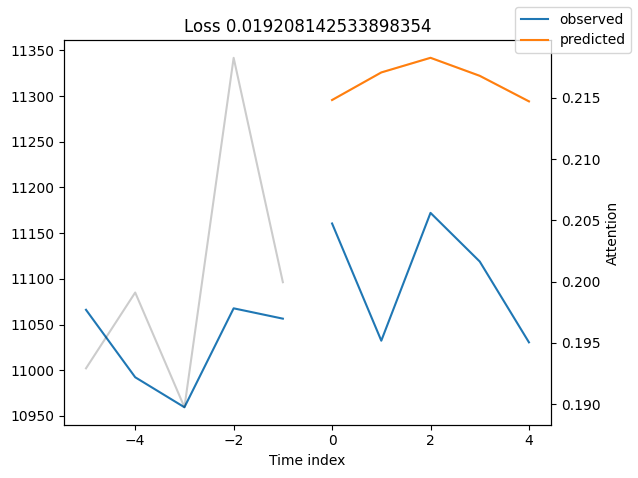

In [16]:
if grid_search:
    tft_predict(best_model, val_dataloader, n_preds=1)


# TEST EVAL

In [17]:
def make_preds(
    train,
    test,
    model,
    encoder_lenght,
    test_lenght,
    pred_lenght,
    quantiles: bool = True,
):
    # group = model.output_transformer.groups[0]
    if quantiles:
        try:  # for Quantileloss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
                prediction = []
                for i in range(pred_lenght):
                    prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
                preds.append(prediction)
        except:  # for MQF2DistributionLoss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                prediction = model.to_prediction(new_raw_predictions.output)[0].flatten().tolist()
                preds.append(prediction)
    else:
        preds = []
        preds_data = pd.concat([train[-encoder_lenght:], test])
        for i in range(0, test_lenght, pred_lenght):
            new_data = preds_data[i : i + encoder_lenght + pred_lenght]
            new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
            new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
            prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
            preds.append(prediction)

    return preds

In [18]:
# preds = []
# preds_data = pd.concat([data[-n_prev_len:], test])
# # preds_data = preds_data.ffill()
# preds_data["target"] = float(1)
# # preds_data.drop(columns=["target"], inplace=True)
# for i in range(0, test_len, pred_len):
#     new_data = preds_data[i : i + n_prev_len + pred_len]
#     new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
#     new_raw_predictions = tft.predict(new_data, mode="raw", return_x=True)
#     prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
#     preds.append(prediction)

In [19]:
preds = make_preds(
    train=data,
    test=test,
    model=tft,
    encoder_lenght=n_prev_len,
    test_lenght=test_len,
    pred_lenght=pred_len,
    quantiles=True if isinstance(loss, QuantileLoss) else False,
)

NameError: name 'tft' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

dates = test["Date"].to_list()
preds_flat = [item for sublist in preds for item in sublist]

# real_vals = list(data[-n_preds * pred_len :]["target"])
real_vals = test["target"].to_list()

print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")

plt.plot(dates, preds_flat, color="r")
plt.plot(dates, real_vals, color="g")
plt.title("Real vs Preds")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.dates as mdates

# Convertir las fechas a formato de datetime si no están ya
dates = pd.to_datetime(test["Date"]).to_list()

# Aplanar las predicciones si es necesario
preds_flat = [item for sublist in preds for item in sublist]

# Valores reales
real_vals = test["target"].to_list()

# Métricas de error
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {mean_squared_error(real_vals, preds_flat, squared=False)}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(dates, real_vals, color="g", label="Valores Reales")
plt.plot(dates, preds_flat, color="r", label="Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Valor (€)")

# Formato de fecha en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotar fechas para mejor visualización

# Añadir leyenda
plt.legend()

# Mostrar gráfico
plt.show()

: 

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supongamos que `preds`, `test`, y `dates` ya están definidos en tu entorno

# Aplanar la lista de predicciones
preds_flat = [item for sublist in preds for item in sublist]

# Convertir los valores reales a una lista
real_vals = test["target"].to_list()

# Lista de fechas (timestamps)


# Calcular el error absoluto medio
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(dates, preds_flat, color="r", label="Predicciones", marker="o", linestyle="--")
plt.plot(dates, real_vals, color="g", label="Valores Reales", marker="x", linestyle="-")

# Añadir título y etiquetas
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Valor")

# Formatear las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotar las etiquetas de fecha

# Añadir cuadrícula y leyenda
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()

: 

# INFERENCE

## Retrain for inference

In [ ]:
features = [
    col for col in data.columns if col != "target"
]  # Columnas de características and col != "Date"

max_prediction_length = pred_len
max_encoder_length = n_prev_len  # 48
# training_cutoff = data["Date"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length

retrain = TimeSeriesDataSet(
    full.dropna()[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Date", "month", "week", "day", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        "vol",
        "var",
        "SMA_5",
        "EMA_5",
        "SMA_10",
        "EMA_10",
        "SMA_15",
        "EMA_15",
        "SMA_20",
        "EMA_20",
        "RSI_6",
        "RSI_10",
        "RSI_14",
        "Bollinger_Upper_5",
        "Bollinger_Lower_5",
        "Bollinger_Upper_10",
        "Bollinger_Lower_10",
        "Bollinger_Upper_15",
        "Bollinger_Lower_15",
        "Bollinger_Upper_20",
        "Bollinger_Lower_20",
        "MACD",
        "Signal_Line",
        "ATR_5",
        "ATR_10",
        "ATR_15",
        "ATR_20",
        "CCI_5",
        "CCI_10",
        "CCI_15",
        "CCI_20",
        "ROC_10",
        "ROC_14",
        "ROC_20",
        "ROC_50",
        "Stochastic_10_K",
        "Stochastic_10_D",
        "Stochastic_14_K",
        "Stochastic_14_D",
        "Stochastic_20_K",
        "Stochastic_20_D",
        "Stochastic_25_K",
        "Stochastic_25_D",
        "Stochastic_50_K",
        "Stochastic_50_D",
        "Williams_%R_10",
        "Williams_%R_14",
    ],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

revalidation = TimeSeriesDataSet.from_dataset(retrain, full.dropna(), predict=True, stop_randomization=True)

# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)


# create dataloaders for model

batch_size = 64  # set this between 32 to 128

retrain_dataloader = retrain.to_dataloader(

    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True

)

reval_dataloader = revalidation.to_dataloader(

    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True

)

# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

if not grid_search:

    # tft_params["learning_rate"] = 0.01

    retft, val_loss = tft_trainer(

        retrain, retrain_dataloader, reval_dataloader, max_epochs=epochs, **tft_params

    )

: 

In [ ]:
encoder_data = full[-n_prev_len:]
last_row = full.iloc[-1]
# Creamos nuevas filas
new_rows = []
for i in range(1, 6):
    new_row = last_row.copy()
    new_row["Date"] += timedelta(days=i)
    new_row["day"] += i
    new_row["time_idx"] += i
    new_rows.append(new_row)

# Concatenamos las nuevas filas al DataFrame original
decoder_data = pd.DataFrame(new_rows)

new_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
# new_data.loc[-pred_len: ,"target"] = 1
new_raw_predictions = retft.predict(new_data, mode="raw", return_x=True)
if isinstance(loss, QuantileLoss):
    prediction = []
    for i in range(pred_len):
        prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
else:
    prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
prediction

: 

In [ ]:
# prediction = [11233.22265625, 11129.837890625, 11228.3486328125, 11315.59375, 11555.85546875]
last_vals = full[-10:]
last_vals = last_vals[["Date", "target"]]
fechas_azul = pd.date_range(start="2024-08-26", periods=len(prediction))
predictions = pd.DataFrame({"Date": fechas_azul, "target": prediction})

plt.plot(predictions["Date"], predictions["target"], color="r")
plt.plot(last_vals["Date"], last_vals["target"], color="g")
plt.title("Gráfica de la lista aplanada")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

: 

# INTERPRETABILITY

In [ ]:
interpretation = tft.interpret_output(preds.output, reduction="sum") #
tft.plot_interpretation(interpretation)


: 

: 